## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [43]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [44]:
df.shape #number of rows and columns in our dataset

(294478, 5)

c. The number of unique users in the dataset.

In [45]:
df['user_id'].nunique() #number of unique users in our dataset

290584

d. The proportion of users converted.

In [46]:
df['converted'].mean()  #proportion of users converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [47]:
#number of times the new_page and treatment don't line up.
a=df.query("landing_page=='new_page' & group=='control'").shape[0]
b=df.query("landing_page=='old_page' & group=='treatment'").shape[0]
a+b

3893

f. Do any of the rows have missing values?

In [48]:
df.isnull().sum() 

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There is no missing values in our dataset

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [49]:
i=df.query("landing_page=='new_page' & group=='control'").index
j=df.query("landing_page=='old_page' & group=='treatment'").index
df2=df.drop(i)
df2=df2.drop(j)

In [50]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [51]:
df2['user_id'].nunique() #number of unique user_ids

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [52]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id'] #duplicated user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [53]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [54]:
df2.drop(2893, inplace= True) #dropping the duplicated user_id

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [55]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [56]:
df2['converted'].mean() #mean of the converted pages

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [57]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [58]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [59]:
len(df2.query('landing_page== "new_page"'))/len(df2['landing_page'])

0.5000619442226688

In [60]:
df['timestamp'].min(), df['timestamp'].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

e.  Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions? Write your response below.



-Given that an individual was in the control group, the probability they converted is 0.12038

-Given that an individual was in the treatment group, what is the probability they converted is 0.11880

-Mathmatically this indicates that the old page is better than the new one. However, the two probablities are very close to each other so we cant decide which page is better.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### H0 (null hypotheses): P𝑜𝑙𝑑-P𝑛𝑒𝑤>=0
#### H1 (alternative hypotheses): P𝑜𝑙𝑑-P𝑛𝑒𝑤<0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [61]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **convert rate** for $p_{new}$ under the null? 

In [62]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [63]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [64]:
n_new=len(df2.query('group== "treatment"'))
n_new

145310

d. What is $n_{old}$?

In [65]:
n_old = len(df2.query('group== "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [66]:
new_page_converted=np.random.choice([1,0], n_new, [p_new,1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [67]:
old_page_converted= np.random.choice([1,0] ,n_old, [p_old,1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [68]:
p_diff = new_page_converted.mean()- old_page_converted.mean()
p_diff


0.00010311332249257621

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [69]:
new_page_converted = new_page_converted[:145274]

In [70]:
p_diffs=[]
for _ in range(10000):
    old_page_converted_mean= np.random.choice([1,0] ,size= n_old, p= [p_old,1-p_old]).mean()
    new_page_converted_mean=np.random.choice([1,0], size= n_new, p= [p_new,1-p_new]).mean()
    diff=new_page_converted_mean-old_page_converted_mean
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'10000 simulated p_diffs')

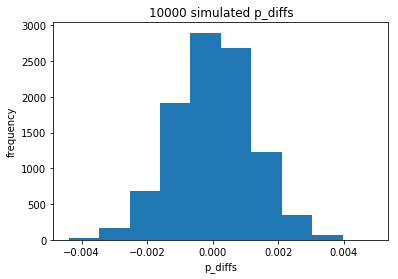

In [71]:
plt.hist(np.array(p_diffs))
plt.xlabel('p_diffs')
plt.ylabel('frequency')
plt.title('10000 simulated p_diffs')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [72]:
obs=df2.query('group == "treatment"')['converted'].mean()- df2.query('group == "control"')['converted'].mean()
obs

-0.0015782389853555567

In [73]:
(obs< np.array(p_diffs)).mean()

0.90890000000000004

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

-We computed the p-value in part j.


-The probability of finding the observed, or more extreme, results when the null hypothesis is true.

-The p-value is around 0.90 wich is high, and indicates that the old page is performing better or the same as the new one.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [74]:
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [75]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old, n_new],alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


In [76]:
from scipy.stats import norm
print(norm.cdf(z_score))
# Tells us how significant our z-score is

print(norm.ppf(1-(0.05/2)))
# Tells us what our critical value at 95% confidence is

0.905058312759
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

We accept the null hupothesis, since the z-score= 1.3109 is less than the critical value of 1.9599.

Our findings in park k agree that of part j.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### We should use the Logestic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [77]:
df['intercept']=1
df[['control', 'treatment']]=pd.get_dummies(df['group'])
df['ab_page']=df['treatment']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [78]:
import statsmodels.api as sm
logit= sm.Logit(df['converted'], df[['intercept','ab_page']])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.366243
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [79]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294476
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Oct 2018   Pseudo R-squ.:               7.093e-06
Time:                        04:32:25   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
                                        LLR p-value:                    0.2161
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9887      0.008   -248.297      0.000      -2.004      -1.973
ab_page       -0.0140      0.011     -1.237      0.216      -0.036       0.008
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.216 which differs from the p-value calculated in Part II since we are using two different ways of testing and computing it.

H0 (null hypotheses): P𝑜𝑙𝑑-P𝑛𝑒𝑤>=0

H1 (alternative hypotheses): P𝑜𝑙𝑑-P𝑛𝑒𝑤<0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

-It is a good idea to consider other factors into our regression model which may affect the conversions.

-We can add factors like, age of the user, education level, gender. These factors may help us in analysing the conversion.

-One of the disadvantages of adding additional terms into our regression is multicollinearity between the independent variables.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [80]:
c_df=pd.read_csv("countries.csv")
c_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [81]:
new_df= c_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
new_df.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [82]:
new_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [83]:
new_df[['CA', 'US']]=pd.get_dummies(new_df['country'])[['CA','US']]
new_df.head()

,country,timestamp,group,landing_page,converted,CA,US
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [84]:
new_df['intercept']=1
logit=sm.Logit(new_df['converted'],new_df[['intercept','CA','US']])
result=logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 13 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        04:32:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

Since the p-value for tested variables is greater than 0.05, then we can conclude that  variables in our logistic regression model appear to have NO statistically significant relationships with conversion.

## Final Conclusion:

After analysing the data we have with several testing methoda, we can accept the null hypothesis by keeping the old page and reject and alternative hypothesis.